In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import itertools
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

from gensim import corpora, models
import gensim

[nltk_data] Downloading package punkt to /home/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read the posts csv file

In [2]:
df_posts = pd.read_csv("../data/raw/computerscience_posts.csv")
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,NaN,1.642048e+09
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,NaN,1.642101e+09
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09


# Proprocess the text

#### Tokenize sentences

In [3]:
# Tokenize the title
df_posts['title'] = df_posts['title'].fillna('')
df_posts['title_token'] = df_posts['title'].apply(sent_tokenize)
df_posts['body'] = df_posts['body'].fillna('')
df_posts['body_token'] = df_posts['body'].apply(sent_tokenize)
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09,[THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER ...,[Tech Support: /r/techsupport\n\nComputer Reco...
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,,1.642048e+09,[This book demonstrates an infinite loop in a ...,[]
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,,1.642101e+09,[Novel view tennis from single camera input],[]
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09,[Confirmation on if I am understanding hardwar...,[Recently I have begun learning about how comp...


#### Tokenize words

In [4]:
def word_tokenize_helper(s):
    if len(s)==0:
        return word_tokenize('')
    else:
        return word_tokenize(s[0])

df_posts['title_word_tokens'] = df_posts['title_token'].apply(lambda s: word_tokenize_helper(s))
df_posts['body_word_tokens'] = df_posts['body_token'].apply(lambda s: word_tokenize_helper(s))
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token,title_word_tokens,body_word_tokens
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived..."
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09,[THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER ...,[Tech Support: /r/techsupport\n\nComputer Reco...,"[THIS, IS, NOT, A, TECH, SUPPORT, SUB, OR, A, ...","[Tech, Support, :, /r/techsupport, Computer, R..."
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,,1.642048e+09,[This book demonstrates an infinite loop in a ...,[],"[This, book, demonstrates, an, infinite, loop,...",[]
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,,1.642101e+09,[Novel view tennis from single camera input],[],"[Novel, view, tennis, from, single, camera, in...",[]
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09,[Confirmation on if I am understanding hardwar...,[Recently I have begun learning about how comp...,"[Confirmation, on, if, I, am, understanding, h...","[Recently, I, have, begun, learning, about, ho..."


#### Initial frequency plot of words

In [5]:
def plot_freq_dist(words, num_words = 20, title=''):
    '''Frequency distribution'''
    #plt.figure(figsize = (14, 8), facecolor=None)
    plt.figure(figsize = (14,8), facecolor=None)
    fdist = FreqDist(words)
    fdist.plot(num_words, cumulative=False, title=title)

In [6]:
all_words = df_posts['title_word_tokens'].to_list()

all_words_flatten = list(itertools.chain(*all_words))

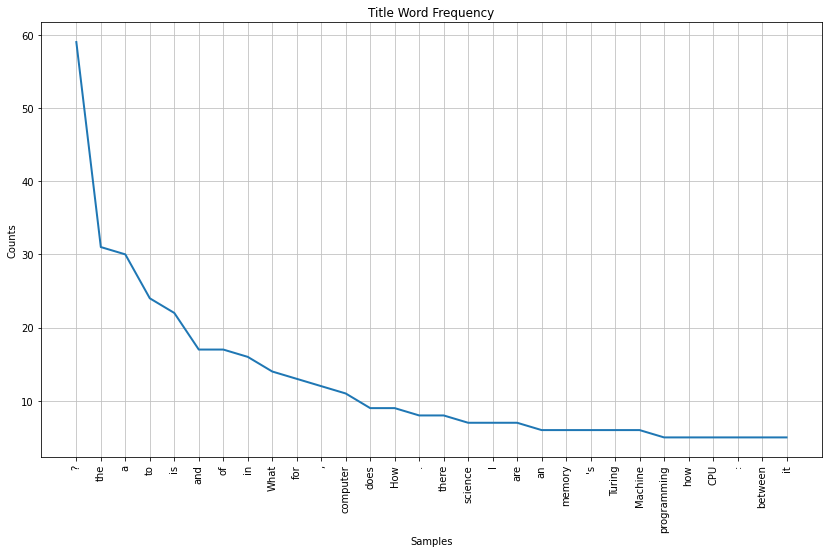

In [7]:
%matplotlib inline
plot_freq_dist(all_words_flatten, num_words=30, title='Title Word Frequency')

### Clean up words

#### Filter punctuation and stopwords

In [8]:
stop_words = set(stopwords.words('english'))

def get_clean_sentences(sentences, remove_digits=False):
    '''Cleaning sentences by removing special characters and optionally digits'''
    clean_sentences = []
    for sent in sentences:
        pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]' 
        clean_text = re.sub(pattern, '', sent)
        clean_text = clean_text.lower()  # Converting to lower case
        clean_sentences.append(clean_text)
    # print('\nClean sentences:', clean_sentences)
    return clean_sentences

def filter_stopwords(words):
    '''Removing stopwords from given words'''
    filtered_words = [w for w in words if w not in stop_words]
    # print('\nFiltered words:', filtered_words)
    return filtered_words

In [9]:
df_posts['title_filtered'] = df_posts['title_word_tokens'].apply(get_clean_sentences)
df_posts['title_filtered'] = df_posts['title_filtered'].apply(filter_stopwords)
df_posts['title_filtered'] = df_posts['title_filtered'].apply(lambda s: list(filter(None, s)))

df_posts['body_filtered'] = df_posts['body_word_tokens'].apply(get_clean_sentences)
df_posts['body_filtered'] = df_posts['body_filtered'].apply(filter_stopwords)
df_posts['body_filtered'] = df_posts['body_filtered'].apply(lambda s: list(filter(None, s)))

In [10]:
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token,title_word_tokens,body_word_tokens,title_filtered,body_filtered
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com..."
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09,[THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER ...,[Tech Support: /r/techsupport\n\nComputer Reco...,"[THIS, IS, NOT, A, TECH, SUPPORT, SUB, OR, A, ...","[Tech, Support, :, /r/techsupport, Computer, R...","[tech, support, sub, computer, recommendation,...","[tech, support, rtechsupport, computer, recomm..."
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,,1.642048e+09,[This book demonstrates an infinite loop in a ...,[],"[This, book, demonstrates, an, infinite, loop,...",[],"[book, demonstrates, infinite, loop, pretty, c...",[]
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,,1.642101e+09,[Novel view tennis from single camera input],[],"[Novel, view, tennis, from, single, camera, in...",[],"[novel, view, tennis, single, camera, input]",[]
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09,[Confirmation on if I am understanding hardwar...,[Recently I have begun learning about how comp...,"[Confirmation, on, if, I, am, understanding, h...","[Recently, I, have, begun, learning, about, ho...","[confirmation, understanding, hardwaresoftware...","[recently, begun, learning, computers, actuall..."


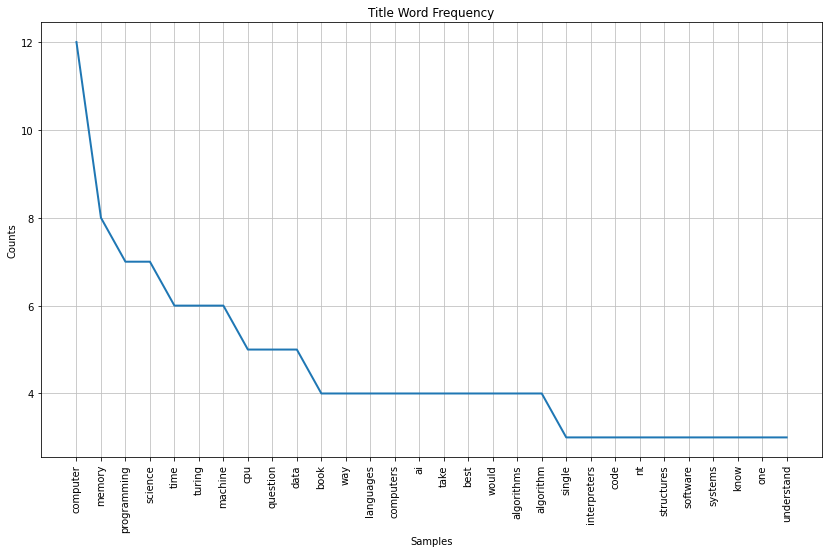

In [11]:
all_words = df_posts['title_filtered'].to_list()

all_words_flatten = list(itertools.chain(*all_words))

%matplotlib inline
plot_freq_dist(all_words_flatten, num_words=30, title='Title Word Frequency')

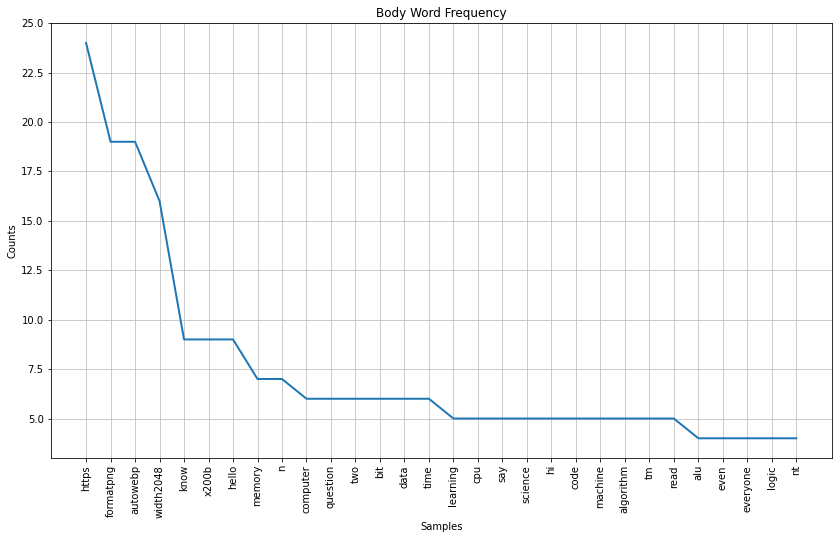

In [12]:
all_words = df_posts['body_filtered'].to_list()

all_words_flatten = list(itertools.chain(*all_words))

%matplotlib inline
plot_freq_dist(all_words_flatten, num_words=30, title='Body Word Frequency')

#### Plot a wordcloud

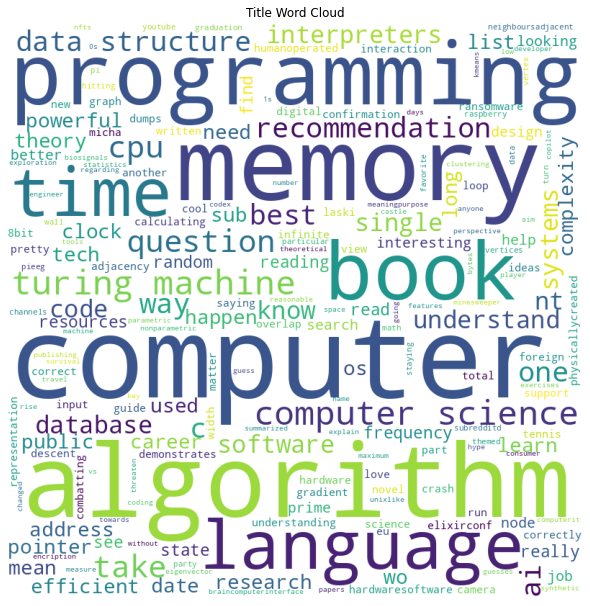

In [13]:
all_words = df_posts['title_filtered'].to_list()
all_words_flatten = list(itertools.chain(*all_words))
all_words_str = (" ").join(all_words_flatten)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_str)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Title Word Cloud")
 
plt.show()

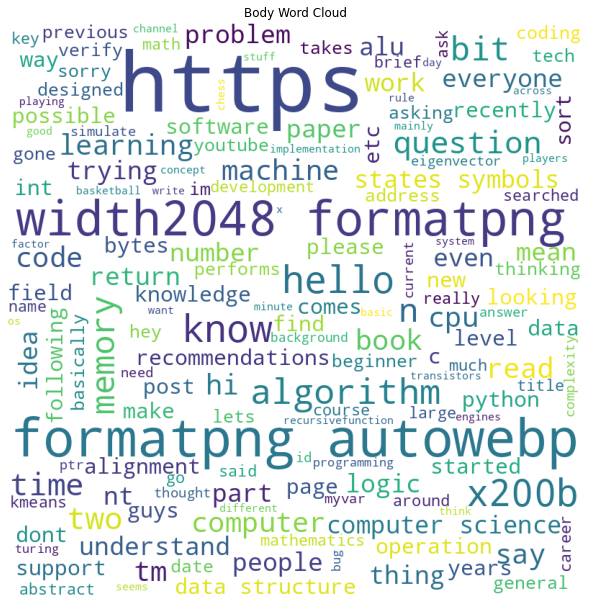

In [14]:
all_words = df_posts['body_filtered'].to_list()
all_words_flatten = list(itertools.chain(*all_words))
all_words_str = (" ").join(all_words_flatten)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_str)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Body Word Cloud")
 
plt.show()

#### EDA on score

In [15]:
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token,title_word_tokens,body_word_tokens,title_filtered,body_filtered
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com..."
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09,[THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER ...,[Tech Support: /r/techsupport\n\nComputer Reco...,"[THIS, IS, NOT, A, TECH, SUPPORT, SUB, OR, A, ...","[Tech, Support, :, /r/techsupport, Computer, R...","[tech, support, sub, computer, recommendation,...","[tech, support, rtechsupport, computer, recomm..."
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,,1.642048e+09,[This book demonstrates an infinite loop in a ...,[],"[This, book, demonstrates, an, infinite, loop,...",[],"[book, demonstrates, infinite, loop, pretty, c...",[]
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,,1.642101e+09,[Novel view tennis from single camera input],[],"[Novel, view, tennis, from, single, camera, in...",[],"[novel, view, tennis, single, camera, input]",[]
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09,[Confirmation on if I am understanding hardwar...,[Recently I have begun learning about how comp...,"[Confirmation, on, if, I, am, understanding, h...","[Recently, I, have, begun, learning, about, ho...","[confirmation, understanding, hardwaresoftware...","[recently, begun, learning, computers, actuall..."


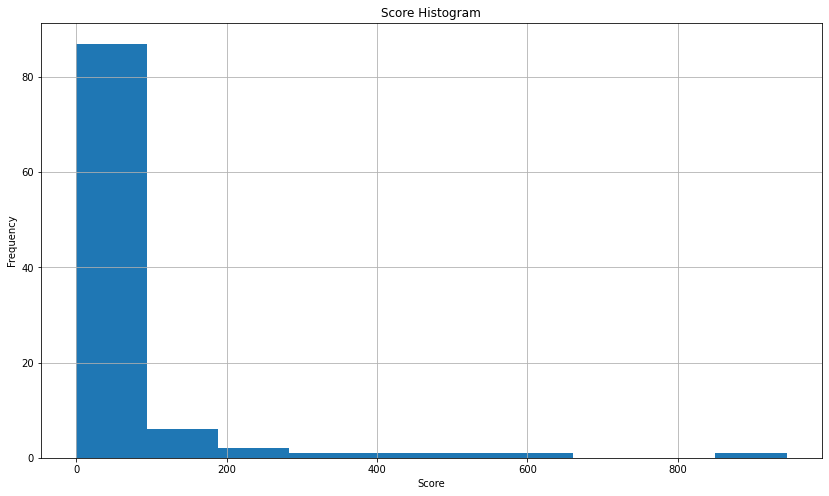

In [16]:
plt.figure(figsize = (14, 8))
df_posts['score'].hist()
plt.title("Score Histogram")
plt.ylabel("Frequency")
plt.xlabel("Score")
plt.show()

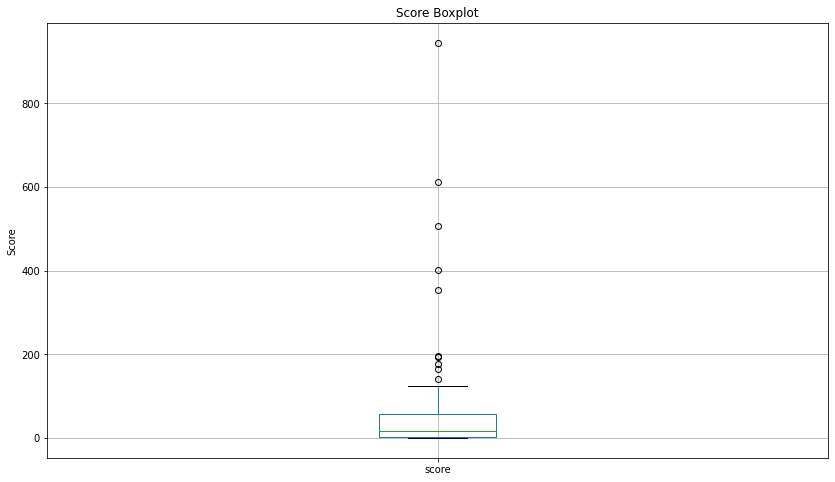

In [17]:
plt.figure(figsize = (14, 8))
df_posts.boxplot(column=['score'])
plt.title("Score Boxplot")
plt.ylabel("Score")
plt.show()

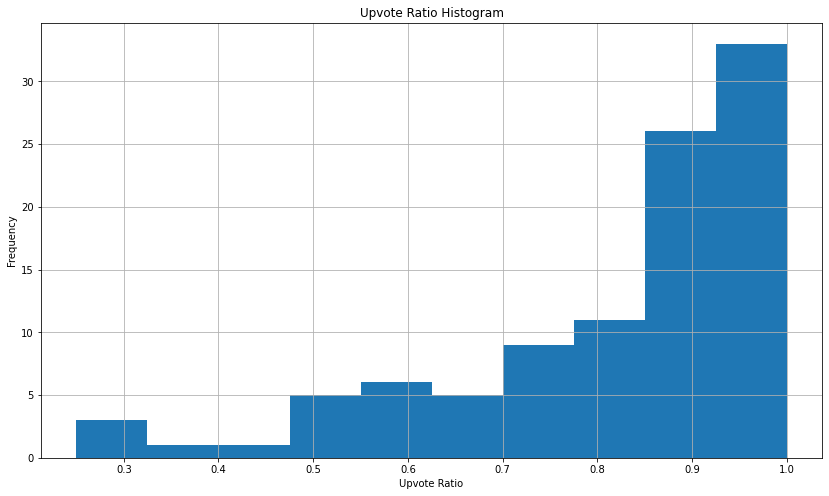

In [18]:
plt.figure(figsize = (14, 8))
df_posts['upvote_ratio'].hist()
plt.title("Upvote Ratio Histogram")
plt.ylabel("Frequency")
plt.xlabel("Upvote Ratio")
plt.show()

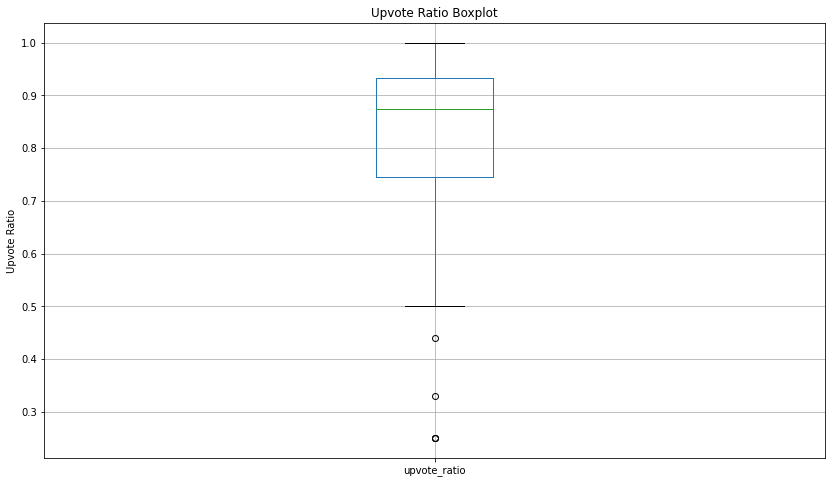

In [19]:
plt.figure(figsize = (14, 8))
df_posts.boxplot(column=['upvote_ratio'])
plt.title("Upvote Ratio Boxplot")
plt.ylabel("Upvote Ratio")
plt.show()

Text(0.5, 0, 'Score')

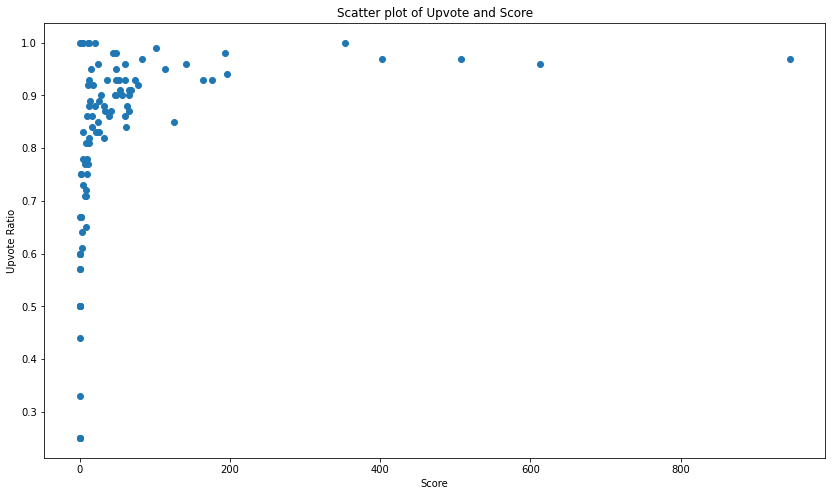

In [20]:
plt.figure(figsize = (14, 8))
plt.scatter(df_posts.score, df_posts.upvote_ratio)
plt.title("Scatter plot of Upvote and Score")
plt.ylabel("Upvote Ratio")
plt.xlabel('Score')

#### Leaving section for stemming and lemming

Stemming

In [21]:
def get_stems(words):
    '''Reduce the words to their base word (stem) by cutting off the ends'''
    ps = PorterStemmer()
    stems = []
    for word in words:
        stems.append(ps.stem(word))
    # print(stems)
    return stems

In [22]:
df_posts['title_stem'] = df_posts['title_filtered'].apply(get_stems)
df_posts['body_stem'] = df_posts['body_filtered'].apply(get_stems)
df_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token,title_word_tokens,body_word_tokens,title_filtered,body_filtered,title_stem,body_stem
0,n2n0ax,New to programming or computer science? Want a...,353,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,..."
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,402,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09,[THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER ...,[Tech Support: /r/techsupport\n\nComputer Reco...,"[THIS, IS, NOT, A, TECH, SUPPORT, SUB, OR, A, ...","[Tech, Support, :, /r/techsupport, Computer, R...","[tech, support, sub, computer, recommendation,...","[tech, support, rtechsupport, computer, recomm...","[tech, support, sub, comput, recommend, sub]","[tech, support, rtechsupport, comput, recommen..."
2,s2qf5f,This book demonstrates an infinite loop in a p...,945,0.97,computerscience,https://i.redd.it/jx92aw75udb81.jpg,26,,1.642048e+09,[This book demonstrates an infinite loop in a ...,[],"[This, book, demonstrates, an, infinite, loop,...",[],"[book, demonstrates, infinite, loop, pretty, c...",[],"[book, demonstr, infinit, loop, pretti, cool, ...",[]
3,s36y35,Novel view tennis from single camera input,13,1.00,computerscience,https://v.redd.it/v6xlgqq17ib81,0,,1.642101e+09,[Novel view tennis from single camera input],[],"[Novel, view, tennis, from, single, camera, in...",[],"[novel, view, tennis, single, camera, input]",[],"[novel, view, tenni, singl, camera, input]",[]
4,s3241k,Confirmation on if I am understanding hardware...,3,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,3,Recently I have begun learning about how compu...,1.642088e+09,[Confirmation on if I am understanding hardwar...,[Recently I have begun learning about how comp...,"[Confirmation, on, if, I, am, understanding, h...","[Recently, I, have, begun, learning, about, ho...","[confirmation, understanding, hardwaresoftware...","[recently, begun, learning, computers, actuall...","[confirm, understand, hardwaresoftwar, interac...","[recent, begun, learn, comput, actual, know, e..."


lemmatization

In [23]:
# def get_lemma(word_tags):
#     '''Reduce the words to their base word (lemma) by using a lexicon'''
#     wordnet_lemmatizer = WordNetLemmatizer()
#     lemma = []
#     for element in word_tags:
#         word = element[0][0]
#         pos = element[0][1]
#         tag = nltk.pos_tag([word])[0][1][0].upper()
#         tag_dict = {"J": wordnet.ADJ, # Mapping NLTK POS tags to WordNet POS tags
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#         wordnet_pos = tag_dict.get(tag, wordnet.NOUN)
#         lemma.append(wordnet_lemmatizer.lemmatize(word, wordnet_pos))
#     print(lemma)
#     return(lemma)

In [24]:
# get_lemma([['hi', 'hello']])

# Topic Modeling (LDA)

In [25]:
posts = list(df_posts['body_stem'])
dictionary = corpora.Dictionary(posts)
corpus = [dictionary.doc2bow(article) for article in 
          posts] # All except the last one

In [26]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, 
                                            id2word = dictionary, 
                                            passes=100)

topic_results = lda_model.print_topics(num_topics=6, num_words=5)
topic_results

[(0,
  '0.013*"comput" + 0.013*"understand" + 0.013*"thing" + 0.013*"think" + 0.013*"hello"'),
 (1,
  '0.012*"symbol" + 0.012*"state" + 0.010*"start" + 0.010*"comput" + 0.010*"know"'),
 (2,
  '0.030*"http" + 0.017*"formatpng" + 0.017*"autowebp" + 0.014*"width2048" + 0.010*"1"'),
 (3,
  '0.014*"bit" + 0.014*"http" + 0.014*"autowebp" + 0.014*"formatpng" + 0.011*"data"'),
 (4,
  '0.029*"http" + 0.026*"width2048" + 0.026*"autowebp" + 0.026*"formatpng" + 0.009*"read"')]

In [27]:
posts = list(df_posts['title_stem'])
dictionary = corpora.Dictionary(posts)
corpus = [dictionary.doc2bow(article) for article in 
          posts] # All except the last one

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, 
                                            id2word = dictionary, 
                                            passes=100)

topic_results = lda_model.print_topics(num_topics=6, num_words=5)
topic_results

[(0,
  '0.024*"machin" + 0.020*"ture" + 0.020*"book" + 0.015*"memori" + 0.015*"way"'),
 (1,
  '0.033*"comput" + 0.019*"program" + 0.019*"algorithm" + 0.015*"languag" + 0.014*"read"'),
 (2,
  '0.017*"time" + 0.017*"program" + 0.017*"list" + 0.017*"guess" + 0.017*"store"'),
 (3,
  '0.045*"comput" + 0.028*"scienc" + 0.017*"code" + 0.012*"one" + 0.012*"softwar"'),
 (4,
  '0.020*"ai" + 0.014*"question" + 0.014*"recommend" + 0.013*"know" + 0.013*"data"')]

IndexError: list index out of range

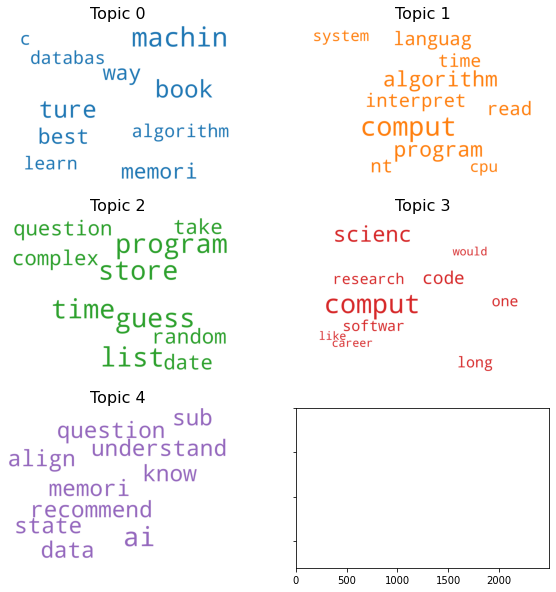

In [29]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Read the comments CSV

In [30]:
df_comments = pd.read_csv("../data/raw/computerscience_comments.csv")
df_comments.head()

,post_id,comment
0,n2n0ax,How late is too late to start a career in prog...
1,n2n0ax,I am a freshman at a university and haven't be...
2,n2n0ax,I'm still in highschool but really interested ...
3,n2n0ax,"This is probably a common question, but how we..."
4,n2n0ax,I am planning on starting a CS major this fall...


# Merge the df comments and posts together

In [31]:
df_merge = df_posts.merge(df_comments, how='outer', left_on='post_id', right_on='post_id')
df_merge.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,title_token,body_token,title_word_tokens,body_word_tokens,title_filtered,body_filtered,title_stem,body_stem,comment
0,n2n0ax,New to programming or computer science? Want a...,353,1.0,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,...",How late is too late to start a career in prog...
1,n2n0ax,New to programming or computer science? Want a...,353,1.0,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,...",I am a freshman at a university and haven't be...
2,n2n0ax,New to programming or computer science? Want a...,353,1.0,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,...",I'm still in highschool but really interested ...
3,n2n0ax,New to programming or computer science? Want a...,353,1.0,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,...","This is probably a common question, but how we..."
4,n2n0ax,New to programming or computer science? Want a...,353,1.0,computerscience,https://www.reddit.com/r/computerscience/comme...,1019,The previous thread was finally archived with ...,1.619890e+09,"[New to programming or computer science?, Want...",[The previous thread was finally archived with...,"[New, to, programming, or, computer, science, ?]","[The, previous, thread, was, finally, archived...","[new, programming, computer, science]","[previous, thread, finally, archived, 500, com...","[new, program, comput, scienc]","[previou, thread, final, archiv, 500, comment,...",I am planning on starting a CS major this fall...


In [32]:
df_merge.comment.isna().sum()

9